Initial Trends Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
indoor_path_1 = "Customer_s Behaviour Case Study\\Indoor Device Data 1.csv"
indoor_path_2 = "Customer_s Behaviour Case Study\\Indoor Device Data 2.csv"
outdoor_path = "Customer_s Behaviour Case Study\\Outdoor Monitor Data.csv"
indoor_metadata_path = "Customer_s Behaviour Case Study\\Indoor Metadata.xlsx"
outdoor_metadata_path = "Customer_s Behaviour Case Study\\Outdoor Metadata.csv"

In [3]:
import chardet

# Check encoding
with open(indoor_path_1, 'rb') as f:
    result = chardet.detect(f.read(100000))
print(result)

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


In [4]:
indoor1 = pd.read_csv(indoor_path_1, sep='\t' ,encoding='UTF-16', low_memory=False)
indoor2 = pd.read_csv(indoor_path_2, sep='\t', encoding='UTF-16', low_memory=False)

# Merge both
indoor = pd.concat([indoor1, indoor2], ignore_index=True)

outdoor = pd.read_csv(outdoor_path, sep='\t', encoding='UTF-16', low_memory=False)
indoor_meta = pd.read_excel(indoor_metadata_path)
outdoor_meta = pd.read_csv(outdoor_metadata_path)


In [5]:
indoor.columns

Index(['Member Uuid', 'Device Name', 'Timestamp', 'Mode', 'Humidity', 'Pm25',
       'Power', 'Speed', 'Temperature'],
      dtype='object')

In [6]:
# Count of missing values
missing_counts = indoor.isnull().sum()
missing_percent = (missing_counts / len(indoor)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by='Missing %', ascending=False)

print(missing_df)


             Missing Count  Missing %
Speed              1483415  70.734807
Humidity           1342679  64.023985
Temperature        1342679  64.023985
Mode                754471  35.976015
Pm25                728944  34.758792
Power               728944  34.758792
Member Uuid              0   0.000000
Device Name              0   0.000000
Timestamp                0   0.000000


In [7]:
indoor = indoor.merge(
    indoor_meta[['Device Name', 'Device Type']],
    on='Device Name',
    how='left'
)

indoor.loc[
    indoor['Device Type'].isin(['pure40', 'pure60']), 'Speed'
] = indoor.loc[
    indoor['Device Type'].isin(['pure40', 'pure60']), 'Speed'
].fillna(0)

In [126]:
indoor.columns

Index(['Member Uuid', 'Device Name', 'Timestamp', 'Mode', 'Humidity', 'Pm25',
       'Power', 'Speed', 'Temperature', 'Device Type'],
      dtype='object')

In [8]:
indoor['Timestamp'] = pd.to_datetime(indoor['Timestamp'], format='%d/%m/%Y %H.%M')
outdoor['Timestamp'] = pd.to_datetime(outdoor['Timestamp'], format='%d %B %Y at %H.%M')

# indoor.set_index('Timestamp', inplace=True)
# outdoor.set_index('Timestamp', inplace=True)

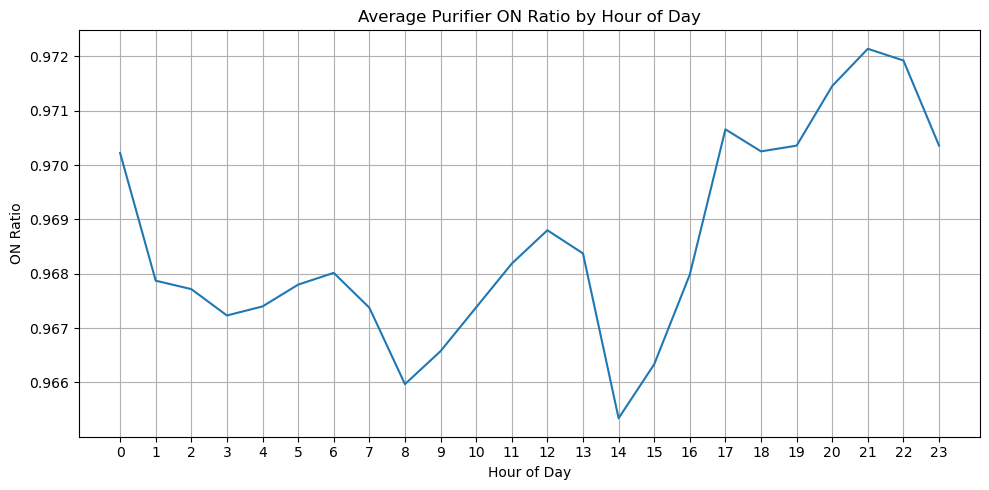

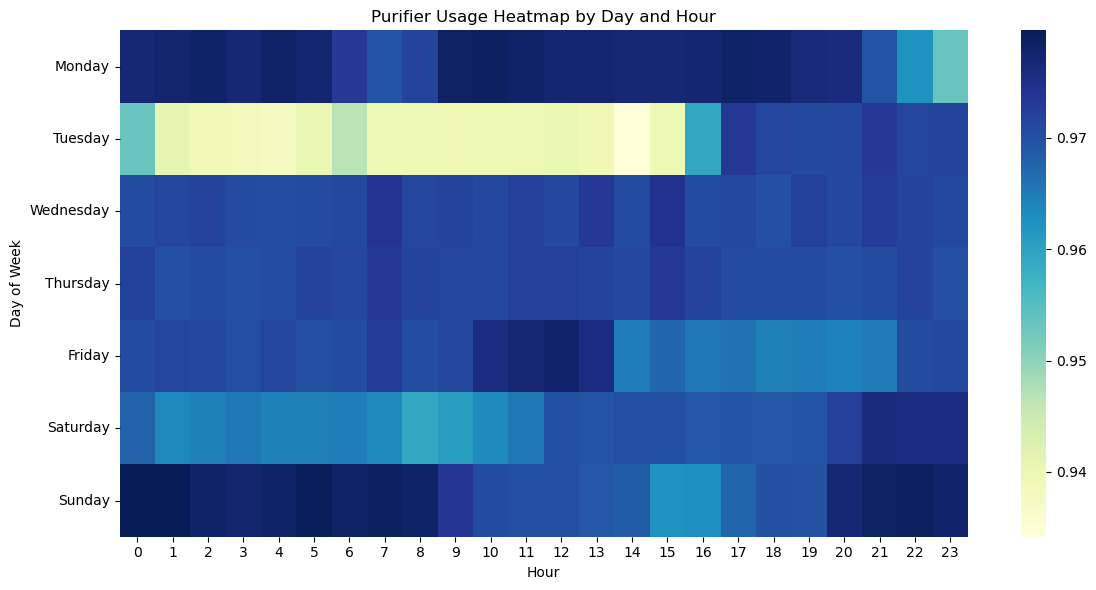

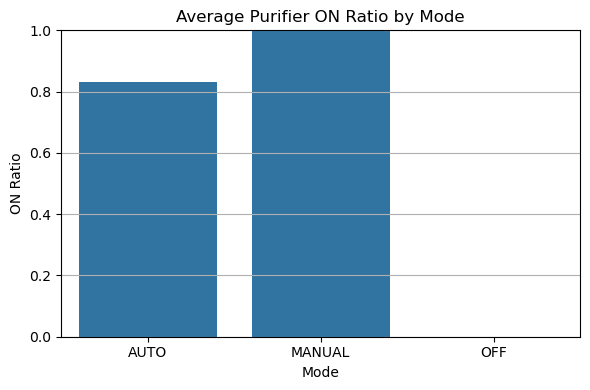

In [128]:
indoor_reset = indoor.reset_index()
indoor_reset['hour'] = indoor_reset['Timestamp'].dt.hour
indoor_reset['dayofweek'] = indoor_reset['Timestamp'].dt.day_name()

# 1. Hourly purifier ON ratio
power_by_hour = indoor_reset.groupby('hour')['Power'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=power_by_hour.index, y=power_by_hour.values)
plt.title("Average Purifier ON Ratio by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("ON Ratio")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# 2. Heatmap of usage (hour x day)
usage_heatmap = indoor_reset.groupby(['dayofweek', 'hour'])['Power'].mean().unstack()
usage_heatmap = usage_heatmap.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(12, 6))
sns.heatmap(usage_heatmap, cmap='YlGnBu', annot=False)
plt.title("Purifier Usage Heatmap by Day and Hour")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

# 3. ON Ratio by Mode (Manual vs Auto)
mode_counts = indoor_reset.groupby('Mode')['Power'].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=mode_counts.index, y=mode_counts.values)
plt.title("Average Purifier ON Ratio by Mode")
plt.ylabel("ON Ratio")
plt.xlabel("Mode")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 4. Per-user summary (Optional: see individual behavior patterns)
user_usage = indoor_reset.groupby(['Device Name', 'Mode'])['Power'].mean().unstack()


In [129]:
display(user_usage.head(10))

Mode,AUTO,MANUAL,OFF
Device Name,,,
Pure40_1f4973,1.000225,1.000257,0.0
Pure40_1f49a7,NaN,1.000259,0.0
Pure40_1f4e37,1.000000,1.000689,0.0
Pure40_1f4ef5,1.000320,1.000000,0.0
Pure40_1f4f51,NaN,1.000223,NaN
Pure40_1f5051,1.000364,1.000000,0.0
Pure60_813120,0.021358,1.000117,NaN
Pure60_816c80,NaN,1.000000,NaN
Pure60_8228b8,NaN,1.000000,NaN


In [130]:
user_usage.to_csv("user_usage_by_mode.csv")


In [131]:
# Average PM2.5 over time
pm25_outdoor_hourly = outdoor['Avg. Pm25'].resample('H').mean()

plt.figure(figsize=(12, 5))
pm25_outdoor_hourly.plot()
plt.title("Outdoor PM2.5 (Hourly Average)")
plt.ylabel("PM2.5 (µg/m³)")
plt.xlabel("Time")
plt.grid(True)
plt.show()

C:\Users\saisr\AppData\Local\Temp\ipykernel_952\1685856727.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pm25_outdoor_hourly = outdoor['Avg. Pm25'].resample('H').mean()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [132]:
indoor.columns

Index(['Member Uuid', 'Device Name', 'Timestamp', 'Mode', 'Humidity', 'Pm25',
       'Power', 'Speed', 'Temperature', 'Device Type'],
      dtype='object')

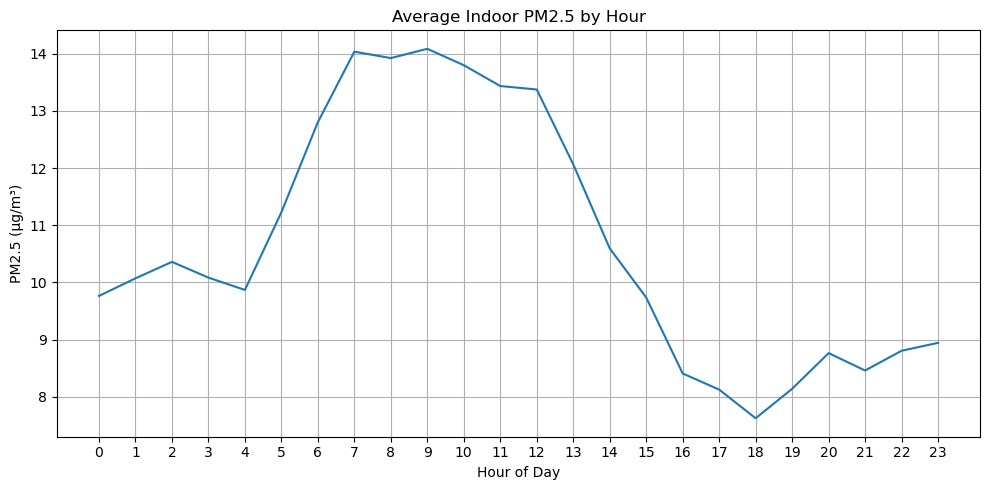

In [141]:
indoor_reset = indoor.reset_index()
indoor_reset['hour'] = indoor_reset['Timestamp'].dt.hour
pm25_by_hour_in = indoor_reset.groupby('hour')['Pm25'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=pm25_by_hour_in.index, y=pm25_by_hour_in.values)
plt.title("Average Indoor PM2.5 by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

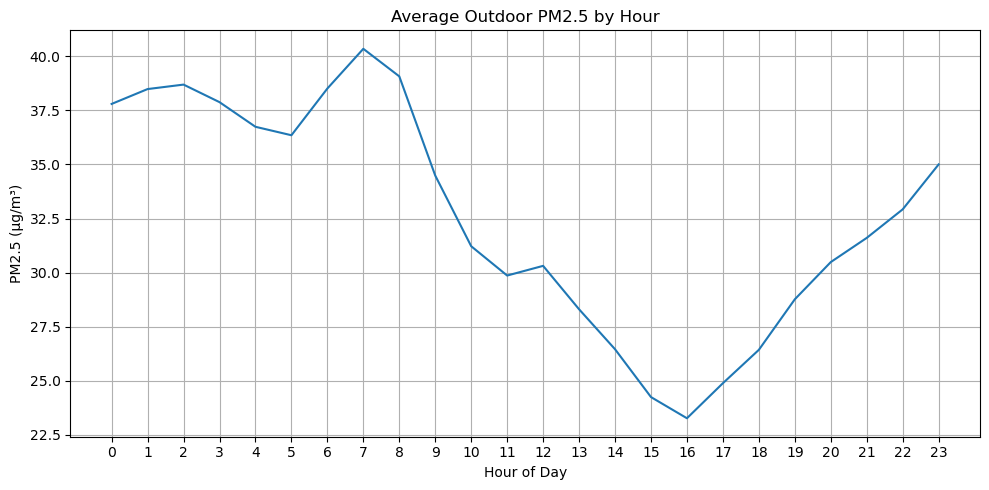

In [ ]:
outdoor_reset = outdoor.reset_index()
outdoor_reset['hour'] = outdoor_reset['Timestamp'].dt.hour
pm25_by_hour_out = outdoor_reset.groupby('hour')['Avg. Pm25'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=pm25_by_hour_out.index, y=pm25_by_hour_out.values)
plt.title("Average Outdoor PM2.5 by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


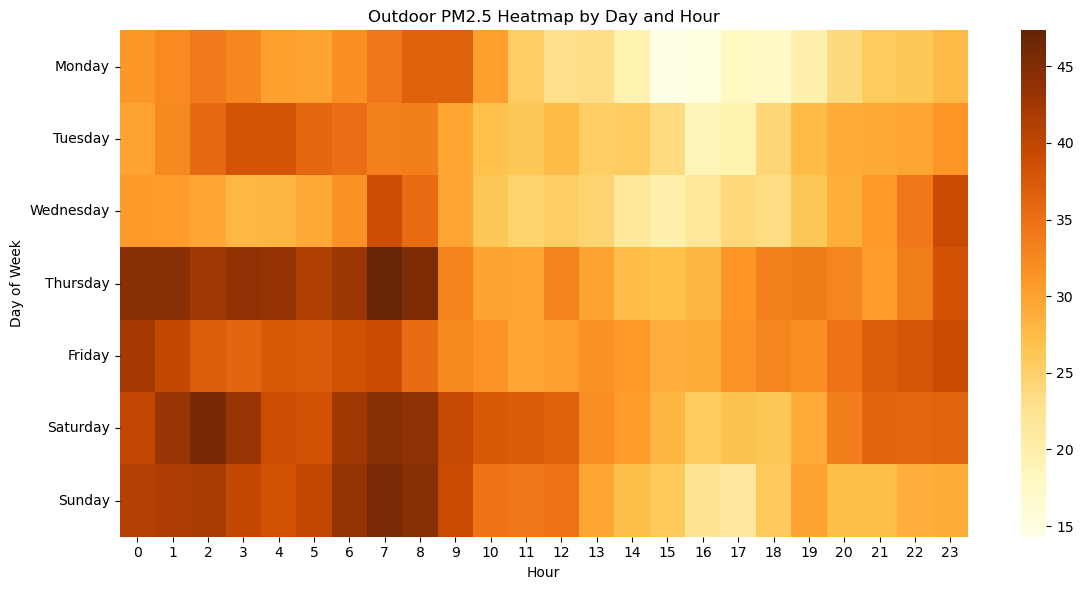

In [ ]:
outdoor_reset['day'] = outdoor_reset['Timestamp'].dt.day_name()
heatmap_out = outdoor_reset.groupby(['day', 'hour'])['Avg. Pm25'].mean().unstack()
heatmap_out = heatmap_out.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_out, cmap='YlOrBr')
plt.title("Outdoor PM2.5 Heatmap by Day and Hour")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


In [ ]:
indoor.columns

Index(['Member Uuid', 'Device Name', 'Mode', 'Humidity', 'Pm25', 'Power',
       'Speed', 'Temperature'],
      dtype='object')

# Scheduling analysis

In [9]:
# View ON ratio and PM2.5 per user
user_stats = indoor.groupby('Device Name').agg({
    'Power': 'mean',
    'Pm25': ['mean', 'max']
})
user_stats.columns = ['ON Ratio', 'Avg PM2.5', 'Max PM2.5']
user_stats = user_stats.sort_values(by='ON Ratio')

display(user_stats.head(10))  # Look for someone with ON ratio < 0.9 and PM2.5 > 30+


,ON Ratio,Avg PM2.5,Max PM2.5
Device Name,,,
Pure60_813120,0.358402,2.866288,46.0
Pure40_1f5051,0.701320,9.243980,189.0
Pure40_1f49a7,0.817785,3.973436,43.0
Pure60_8290f0,0.862172,14.695289,256.0
Pure60_a6e004,0.874926,21.875909,114.0
Pure60_82927c,0.946601,17.598651,139.0
Pure60_a82d4c,0.955634,32.269075,312.0
Pure40_1f4973,0.993488,6.080021,42.0
Pure60_816c80,1.000000,4.887362,57.0


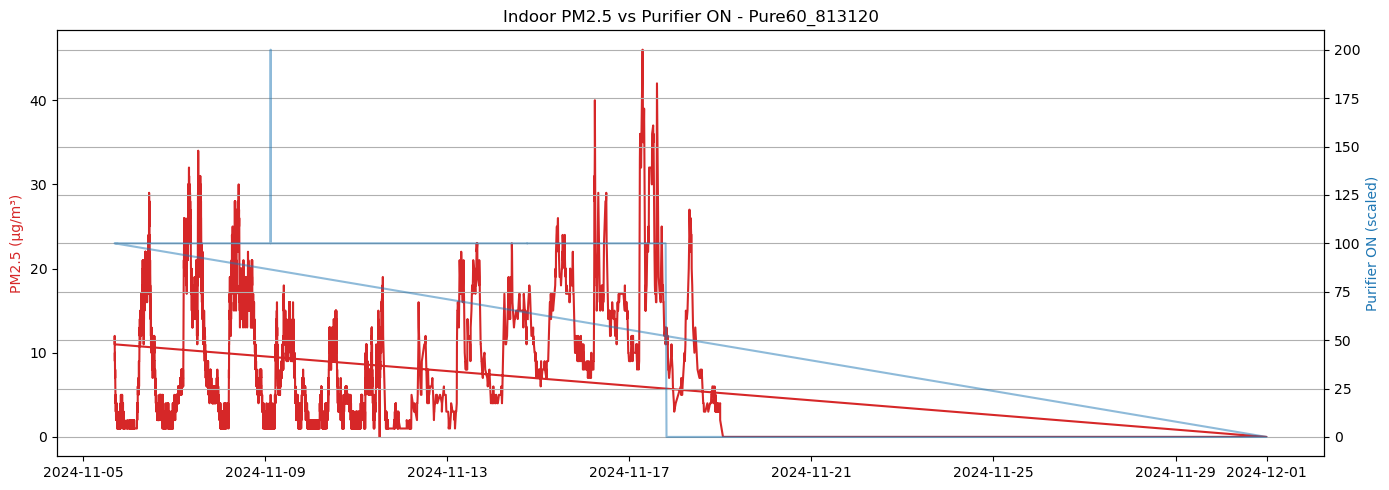

In [ ]:
device_id = "Pure60_813120"  # Replace this with the chosen one
user_indoor = indoor[indoor['Device Name'] == device_id].copy()

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(user_indoor.index, user_indoor['Pm25'], label='Indoor PM2.5', color='tab:red')
ax1.set_ylabel('PM2.5 (µg/m³)', color='tab:red')

# Overlay purifier power (scaled)
ax2 = ax1.twinx()
ax2.plot(user_indoor.index, user_indoor['Power']*100, label='Purifier ON', color='tab:blue', alpha=0.5)
ax2.set_ylabel('Purifier ON (scaled)', color='tab:blue')

plt.title(f"Indoor PM2.5 vs Purifier ON - {device_id}")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 1. % time purifier is ON
on_ratio = user_indoor['Power'].mean()
print(f"🟢 ON Ratio: {on_ratio:.2%}")


# 2. Avg PM2.5 when purifier is ON vs OFF
pm_on = user_indoor[user_indoor['Power'] == 1]['Pm25'].mean()
pm_off = user_indoor[user_indoor['Power'] == 0]['Pm25'].mean()
print(f"🌫️ PM2.5 when ON: {pm_on:.2f}")
print(f"🌫️ PM2.5 when OFF: {pm_off:.2f}")


# 3. PM2.5 threshold at which purifier is manually turned ON (transition points)
user_indoor['Power Shift'] = user_indoor['Power'].diff()
turn_on_events = user_indoor[user_indoor['Power Shift'] == 1]
turn_on_thresholds = turn_on_events['Pm25'].describe()
print("\n📈 PM2.5 Levels When User Turns ON the Purifier:")
print(turn_on_events['Pm25'].describe())


🟢 ON Ratio: 35.84%
🌫️ PM2.5 when ON: 7.91
🌫️ PM2.5 when OFF: 0.05

📈 PM2.5 Levels When User Turns ON the Purifier:
count     2.000000
mean      8.000000
std       4.242641
min       5.000000
25%       6.500000
50%       8.000000
75%       9.500000
max      11.000000
Name: Pm25, dtype: float64


In [ ]:
indoor['Member Uuid'].unique()

array(['5bb696fb-e41a-44bd-b288-5830e671dd73',
       '512f3d17-94ea-4608-8c0a-debf385c6a51',
       '4940f5d2-f23a-4bf7-aa60-4875ffd19a8a',
       'a75f6f00-595e-47e6-b944-18e91a8f6bc9'], dtype=object)

In [ ]:
indoor.head()

,Member Uuid_x,Device Name,Mode,Humidity,Pm25,Power,Speed,Temperature,Device Type,Member Uuid_y,Room Name,Latitude,Longitude
0,5bb696fb-e41a-44bd-b288-5830e671dd73,Pure60_816c80,MANUAL,NaN,17.0,1.0,3.0,NaN,pure60,5bb696fb-e41a-44bd-b288-5830e671dd73,Bed Room,NaN,NaN
1,5bb696fb-e41a-44bd-b288-5830e671dd73,Pure60_816c80,MANUAL,NaN,17.0,1.0,3.0,NaN,pure60,5bb696fb-e41a-44bd-b288-5830e671dd73,Bed Room,NaN,NaN
2,5bb696fb-e41a-44bd-b288-5830e671dd73,Pure60_816c80,MANUAL,NaN,17.0,1.0,3.0,NaN,pure60,5bb696fb-e41a-44bd-b288-5830e671dd73,Bed Room,NaN,NaN
3,5bb696fb-e41a-44bd-b288-5830e671dd73,Pure60_816c80,MANUAL,NaN,17.0,1.0,3.0,NaN,pure60,5bb696fb-e41a-44bd-b288-5830e671dd73,Bed Room,NaN,NaN
4,5bb696fb-e41a-44bd-b288-5830e671dd73,Pure60_816c80,MANUAL,NaN,17.0,1.0,3.0,NaN,pure60,5bb696fb-e41a-44bd-b288-5830e671dd73,Bed Room,NaN,NaN


# Advanced Scheduling Analysis

In [ ]:
indoor.columns


Index(['Member Uuid', 'Device Name', 'Timestamp', 'Mode', 'Humidity', 'Pm25',
       'Power', 'Speed', 'Temperature'],
      dtype='object')

In [ ]:
indoor['Member Uuid'].unique()

array(['4940f5d2-f23a-4bf7-aa60-4875ffd19a8a',
       '512f3d17-94ea-4608-8c0a-debf385c6a51',
       '5bb696fb-e41a-44bd-b288-5830e671dd73',
       'a75f6f00-595e-47e6-b944-18e91a8f6bc9'], dtype=object)

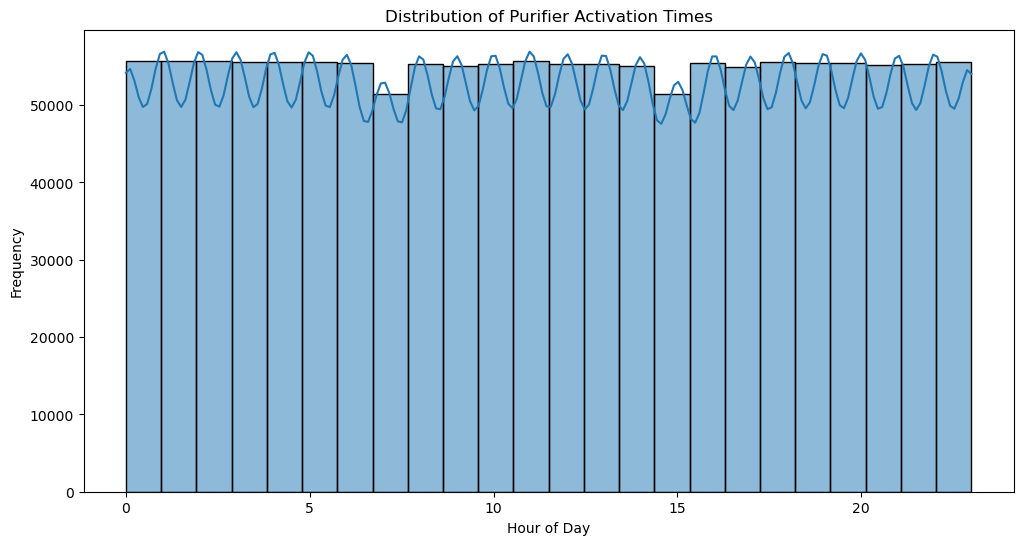

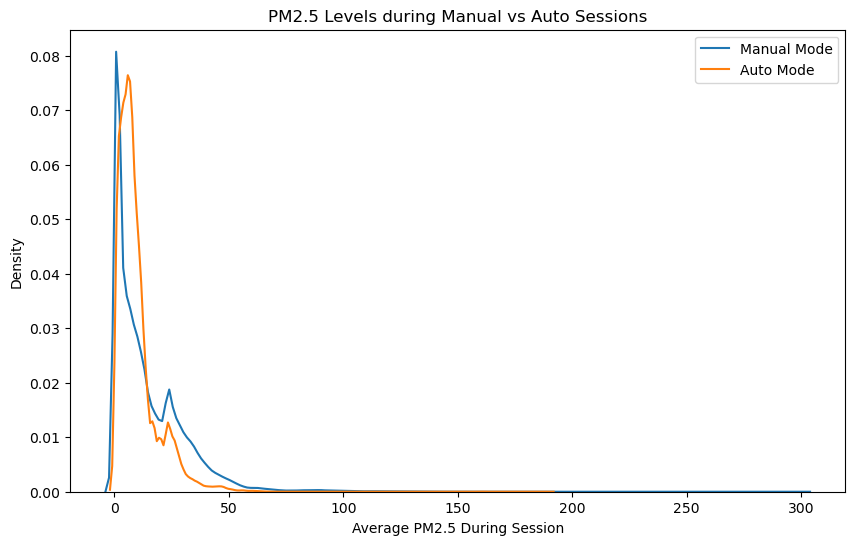

User features shape after cleanup: (4, 4)
                            Member Uuid  avg_session_duration  total_sessions  \
0  4940f5d2-f23a-4bf7-aa60-4875ffd19a8a              0.804026          171666   
1  512f3d17-94ea-4608-8c0a-debf385c6a51              3.334440          158417   
2  5bb696fb-e41a-44bd-b288-5830e671dd73          41988.000000               2   
3  a75f6f00-595e-47e6-b944-18e91a8f6bc9              5.484866           42684   

   manual_mode_ratio  
0           0.666332  
1           0.922180  
2           1.000000  
3           0.824454  


c:\Users\saisr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


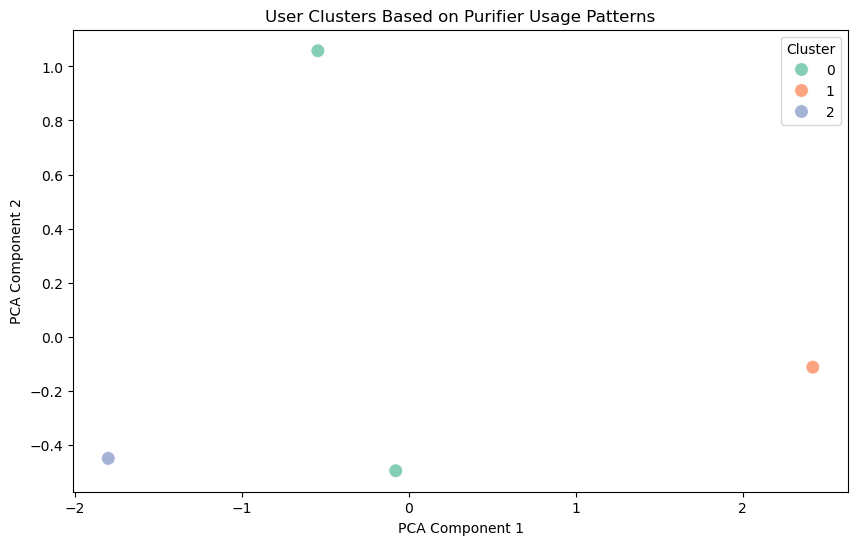

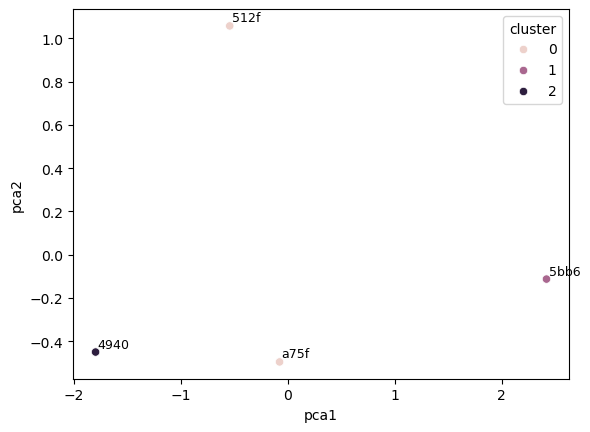

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Optional: adjust display settings
pd.set_option('display.max_columns', None)


# --- STEP 1: Feature Engineering ---
indoor['hour'] = indoor['Timestamp'].dt.hour
indoor['day_of_week'] = indoor['Timestamp'].dt.day_name()
indoor['is_on'] = indoor['Power']
indoor['is_manual_mode'] = indoor['Mode'].apply(
    lambda x: 1 if isinstance(x, str) and x.lower() == 'manual' else 0
)

# Optional: Categorize speed levels
indoor['speed_category'] = pd.cut(indoor['Speed'], bins=[0,1,2,3], labels=['low','medium','high'], right=False)

# --- STEP 2: Session Identification ---
# A new session is when power status goes from off to on
indoor = indoor.sort_values(['Member Uuid', 'Device Name', 'Timestamp'])
indoor['prev_is_on'] = indoor.groupby(['Member Uuid', 'Device Name'])['is_on'].shift(1).fillna(0)
indoor['session_start'] = ((indoor['is_on'] == 1) & (indoor['prev_is_on'] == 0)).astype(int)

# Assign session IDs
indoor['session_id'] = indoor.groupby(['Member Uuid', 'Device Name'])['session_start'].cumsum()
indoor['session_id'] = indoor.apply(lambda row: row['session_id'] if row['is_on'] == 1 else np.nan, axis=1)
indoor['session_id'] = indoor.groupby(['Member Uuid', 'Device Name'])['session_id'].ffill()

# --- STEP 3: Session Summary ---
session_summary = indoor[indoor['is_on'] == 1].groupby(['Member Uuid', 'Device Name', 'session_id']).agg({
    'Timestamp': ['min', 'max', 'count'],
    'Pm25': ['mean', 'max'],
    'Temperature': 'mean',
    'Humidity': 'mean',
    'is_manual_mode': 'mean'
}).reset_index()

session_summary.columns = ['_'.join(col).strip('_') for col in session_summary.columns.values]
session_summary['session_duration_min'] = session_summary['Timestamp_max'] - session_summary['Timestamp_min']
session_summary['session_duration_min'] = session_summary['session_duration_min'].dt.total_seconds() / 60.0

# --- STEP 4: Time-of-Day Patterns ---
plt.figure(figsize=(12,6))
sns.histplot(indoor[indoor['is_on'] == 1]['hour'], bins=24, kde=True)
plt.title("Distribution of Purifier Activation Times")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.show()

# --- STEP 5: Manual vs Auto Behavior ---
manual_sessions = session_summary[session_summary['is_manual_mode_mean'] > 0.5]
auto_sessions = session_summary[session_summary['is_manual_mode_mean'] <= 0.5]

plt.figure(figsize=(10,6))
sns.kdeplot(manual_sessions['Pm25_mean'], label='Manual Mode')
sns.kdeplot(auto_sessions['Pm25_mean'], label='Auto Mode')
plt.title("PM2.5 Levels during Manual vs Auto Sessions")
plt.xlabel("Average PM2.5 During Session")
plt.legend()
plt.show()

# --- STEP 6: User Clustering ---
user_features = session_summary.groupby('Member Uuid').agg(
    avg_session_duration=('session_duration_min', 'mean'),
    total_sessions=('session_id', 'count'),
    manual_mode_ratio=('is_manual_mode_mean', 'mean')
).reset_index()

# Fill missing values with 0
user_features[['avg_session_duration', 'total_sessions', 'manual_mode_ratio']] = user_features[['avg_session_duration', 'total_sessions', 'manual_mode_ratio']].fillna(0)

print("User features shape after cleanup:", user_features.shape)
print(user_features.head())

# Proceed only if data exists
if not user_features.empty:

    # STEP 3: Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(
        user_features[['avg_session_duration', 'total_sessions', 'manual_mode_ratio']]
    )

    # STEP 4: KMeans clustering
    kmeans = KMeans(n_clusters=min(3, len(user_features)), random_state=42)
    user_features['cluster'] = kmeans.fit_predict(scaled_features)

    # STEP 5: PCA for 2D visualization
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(scaled_features)
    user_features['pca1'] = pca_components[:, 0]
    user_features['pca2'] = pca_components[:, 1]

    # STEP 6: Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=user_features,
        x='pca1', y='pca2',
        hue='cluster', palette='Set2',
        s=100, alpha=0.8
    )
    plt.title("User Clusters Based on Purifier Usage Patterns")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Cluster')
    plt.show()

else:
    print("No valid user data available for clustering.")

sns.scatterplot(data=user_features, x='pca1', y='pca2', hue='cluster')
for i, row in user_features.iterrows():
    plt.text(row['pca1']+0.02, row['pca2']+0.02, row['Member Uuid'][:4], fontsize=9)


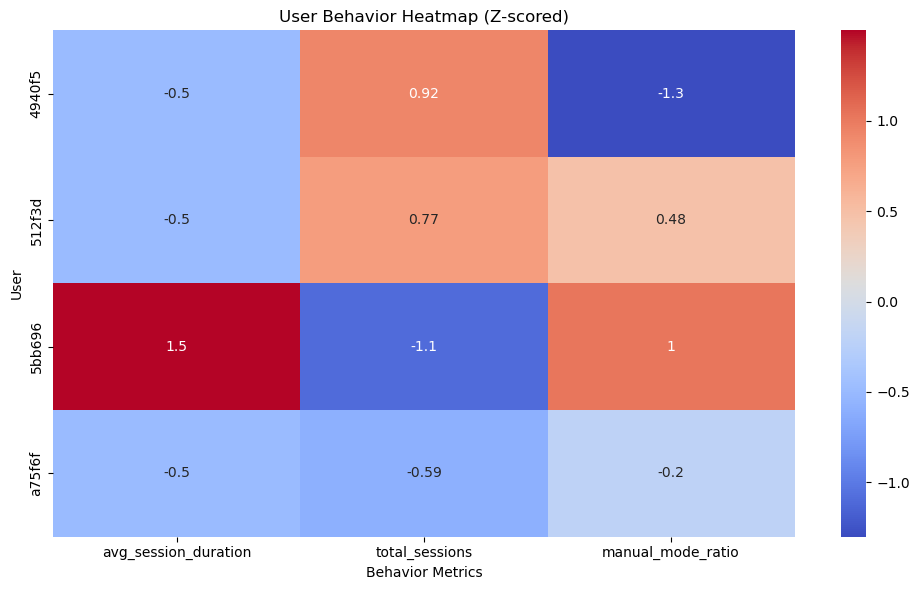

In [ ]:
## HEATMAP 

import seaborn as sns
import matplotlib.pyplot as plt

# Only feature columns
heat_df = user_features[['avg_session_duration', 'total_sessions', 'manual_mode_ratio', 'cluster']]
heat_df.set_index(user_features['Member Uuid'].str[:6], inplace=True)  # Shorten UUIDs

# Normalize each column for comparison (z-score style)
normalized = (heat_df.drop('cluster', axis=1) - heat_df.drop('cluster', axis=1).mean()) / \
             heat_df.drop('cluster', axis=1).std()

plt.figure(figsize=(10, 6))
sns.heatmap(normalized, annot=True, cmap="coolwarm", cbar=True)
plt.title("User Behavior Heatmap (Z-scored)")
plt.ylabel("User")
plt.xlabel("Behavior Metrics")
plt.tight_layout()
plt.show()


In [ ]:
session_summary.columns

Index(['Member Uuid', 'Device Name', 'session_id', 'Timestamp_min',
       'Timestamp_max', 'Timestamp_count', 'Pm25_mean', 'Pm25_max',
       'Temperature_mean', 'Humidity_mean', 'is_manual_mode_mean',
       'session_duration_min'],
      dtype='object')

In [ ]:
indoor.columns

Index(['Member Uuid', 'Device Name', 'Mode', 'Humidity', 'Pm25', 'Power',
       'Speed', 'Temperature', 'Device Type'],
      dtype='object')

Text(0.5, 1.0, 'Purifier Activations by Day and Hour')

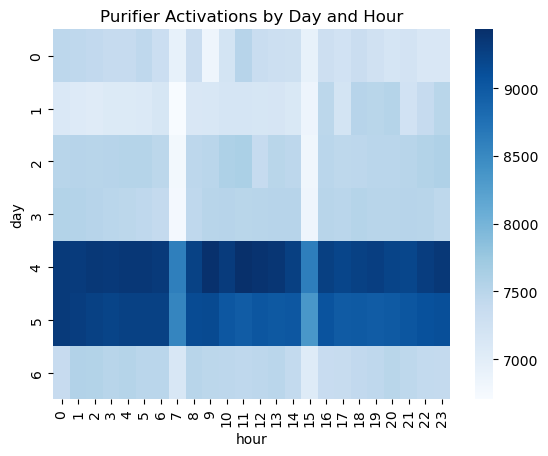

In [140]:
# Example: sessions per hour x day of week
indoor['hour'] = indoor['Timestamp'].dt.hour
indoor['day'] = indoor['Timestamp'].dt.dayofweek  # 0=Monday
heatmap_on_ratio = indoor[indoor['is_on'] == 1].groupby(['day', 'hour']).size().unstack().fillna(0)

sns.heatmap(heatmap_on_ratio, cmap='Blues')
plt.title("Purifier Activations by Day and Hour")


Manual vs Auto ON ratio

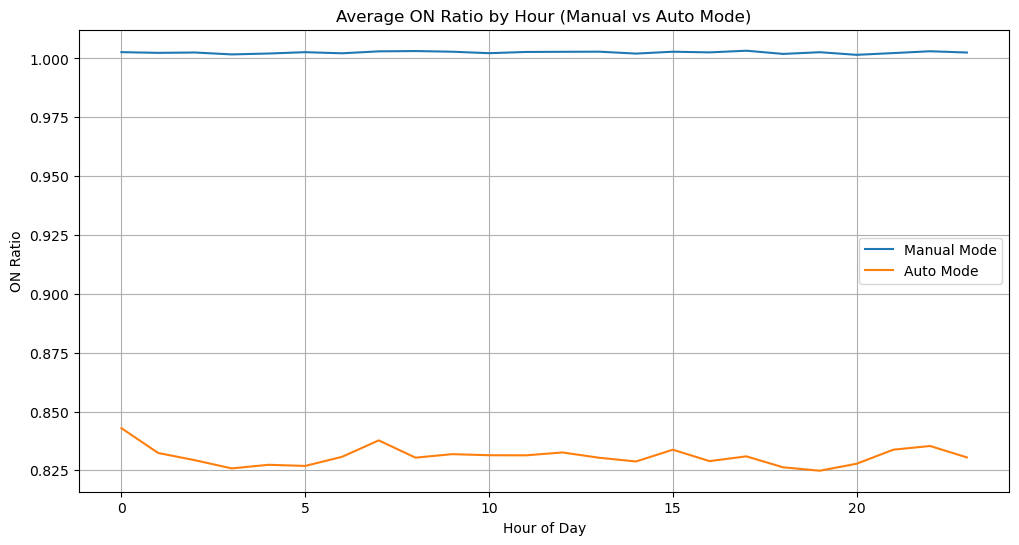

In [137]:
manual = indoor[indoor['Mode'] == 'MANUAL']
auto = indoor[indoor['Mode'] == 'AUTO']

manual_on_ratio = manual.groupby('hour')['Power'].mean()
auto_on_ratio = auto.groupby('hour')['Power'].mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(manual_on_ratio, label='Manual Mode')
plt.plot(auto_on_ratio, label='Auto Mode')
plt.title("Average ON Ratio by Hour (Manual vs Auto Mode)")
plt.xlabel("Hour of Day")
plt.ylabel("ON Ratio")
plt.legend()
plt.grid(True)
plt.show()

In [138]:
print(manual_on_ratio)

hour
0     1.002693
1     1.002392
2     1.002541
3     1.001731
4     1.002108
5     1.002678
6     1.002209
7     1.003031
8     1.003153
9     1.002875
10    1.002252
11    1.002771
12    1.002837
13    1.002891
14    1.002080
15    1.002874
16    1.002594
17    1.003298
18    1.001939
19    1.002664
20    1.001552
21    1.002295
22    1.003070
23    1.002532
Name: Power, dtype: float64


In [139]:
print(auto_on_ratio)

hour
0     0.842941
1     0.832395
2     0.829318
3     0.825843
4     0.827375
5     0.826893
6     0.830761
7     0.837745
8     0.830409
9     0.831894
10    0.831438
11    0.831395
12    0.832614
13    0.830357
14    0.828792
15    0.833780
16    0.828937
17    0.830960
18    0.826312
19    0.824857
20    0.827821
21    0.833796
22    0.835361
23    0.830517
Name: Power, dtype: float64


Correlation between hourly avg PM2.5 and purifier ON ratio: 0.231


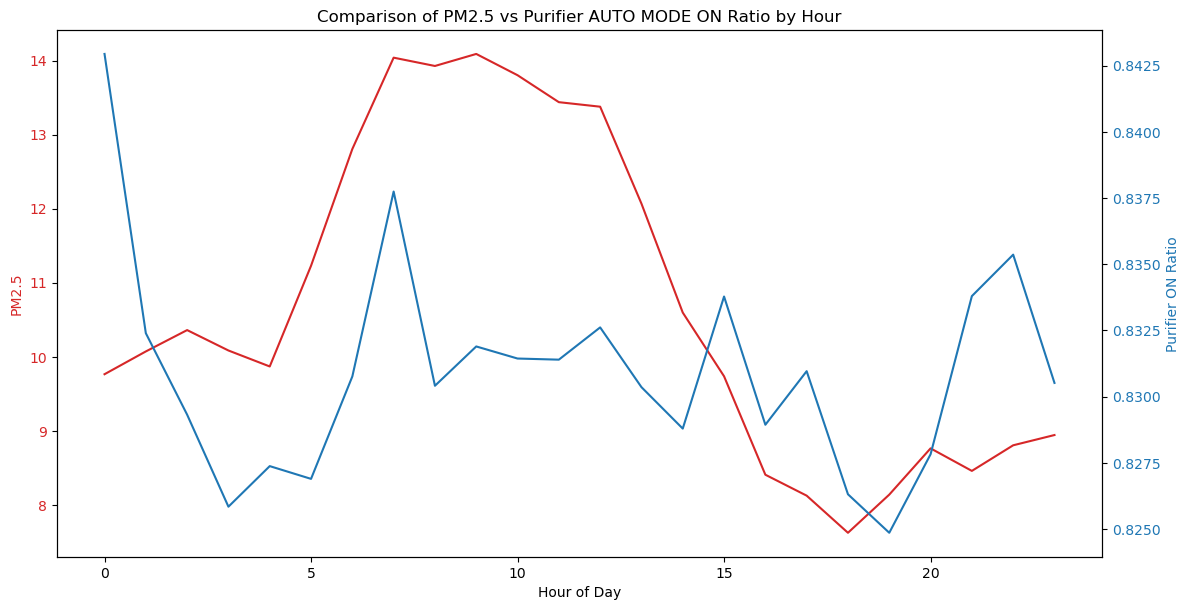

In [146]:
corr = pm25_by_hour_in.corr(auto_on_ratio)
print(f"Correlation between hourly avg PM2.5 and purifier ON ratio: {corr:.3f}")

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('PM2.5', color='tab:red')
ax1.plot(pm25_by_hour_in.index, pm25_by_hour_in.values, color='tab:red', label='PM2.5')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  # second y-axis
ax2.set_ylabel('Purifier ON Ratio', color='tab:blue')
ax2.plot(auto_on_ratio.index, auto_on_ratio.values, color='tab:blue', label='ON Ratio')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title("Comparison of PM2.5 vs Purifier AUTO MODE ON Ratio by Hour")
plt.show()

# Spatial analysis

In [15]:
# Clean merge: keep only unique device info
indoor_meta_unique = indoor_meta.drop_duplicates(subset='Member Uuid')


In [16]:
# Load your data (if not already loaded)
# indoor_data = pd.read_csv("indoor_data.csv")
# indoor_metadata = pd.read_csv("indoor_metadata.csv")

# Merge metadata into main dataset
merged_indoor = indoor.merge(
    indoor_meta[['Member Uuid', 'Device Name', 'Device Type', 'Latitude', 'Longitude']],
    on='Member Uuid',
    how='left'
)


In [17]:
missing_counts = merged_indoor.isnull().sum()
missing_percent = (missing_counts / len(indoor)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by='Missing %', ascending=False)

print(missing_df)

               Missing Count    Missing %
Humidity            23140575  1103.429655
Temperature         23140575  1103.429655
Latitude            20585592   981.598455
Longitude           20585592   981.598455
Mode                15606630   744.182820
Speed               15606630   744.182820
Pm25                12685317   604.883628
Power               12685317   604.883628
Member Uuid                0     0.000000
Device Name_x              0     0.000000
Timestamp                  0     0.000000
Device Type_x              0     0.000000
Device Name_y              0     0.000000
Device Type_y              0     0.000000


In [13]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from geopy.distance import great_circle
import numpy as np

# Prepare location data
coords = merged_indoor[['Latitude', 'Longitude']].values

# DBSCAN with Haversine distance
kms_per_radian = 6371.0088
epsilon = 30 / kms_per_radian  # 30km radius

db = DBSCAN(eps=epsilon, min_samples=3, algorithm='ball_tree', metric='haversine')
merged_indoor['geo_cluster'] = db.fit_predict(np.radians(coords))


ValueError: Input X contains NaN.
DBSCAN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values